In [368]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('fivethirtyeight')

In [369]:
sales_df = pd.read_csv('../input/train.csv', index_col='date', parse_dates=True)
sales_df = sales_df.loc[sales_df['item'] == 1]
sales_df = sales_df.loc['2014-01-01':'2018-01-01']
sales_df.drop(['store', 'item'], axis=1, inplace=True)
# sales_df = sales_df.sort_index()
sales_df = sales_df.groupby(sales_df.index)[['sales']].sum()
sales_df.head()


,sales
date,
2014-01-01,109
2014-01-02,128
2014-01-03,146
2014-01-04,155
2014-01-05,179


In [370]:
sales_df.tail()

,sales
date,
2017-12-27,154
2017-12-28,178
2017-12-29,207
2017-12-30,236
2017-12-31,227


**Plot of sales from Jan 2014 to Dec 2017**

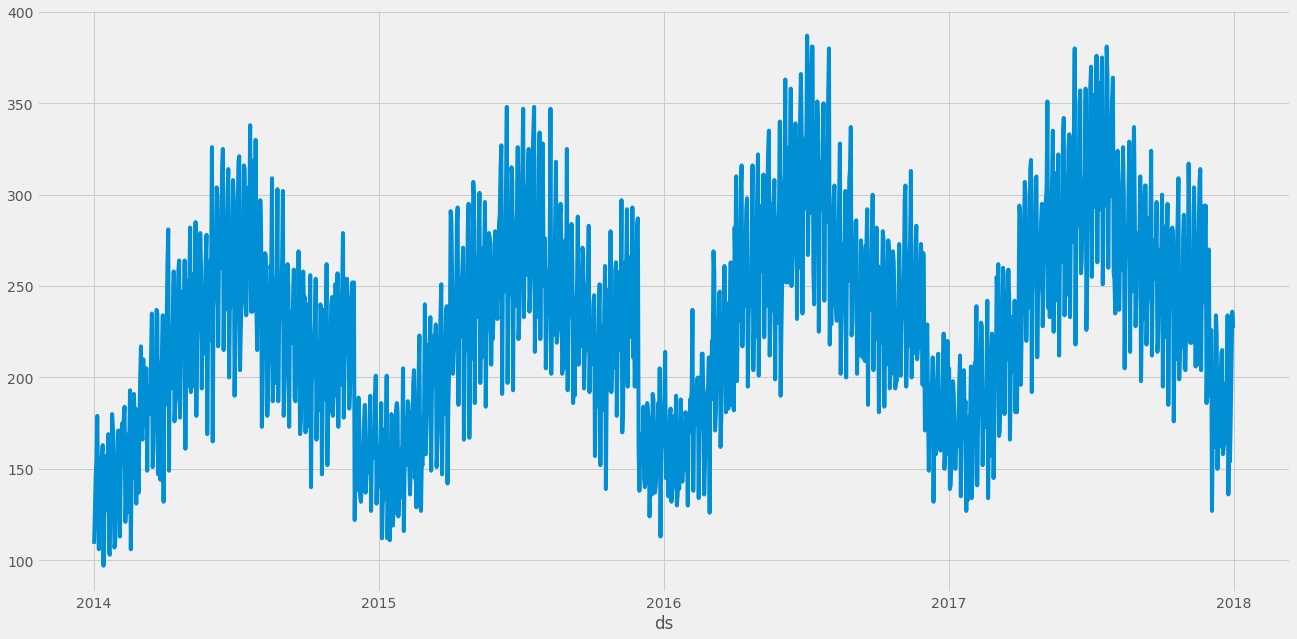

In [371]:
df = sales_df.reset_index()
df=df.rename(columns={'date':'ds', 'sales':'y'})
df.head()
df.set_index('ds').y.plot(grid=True)

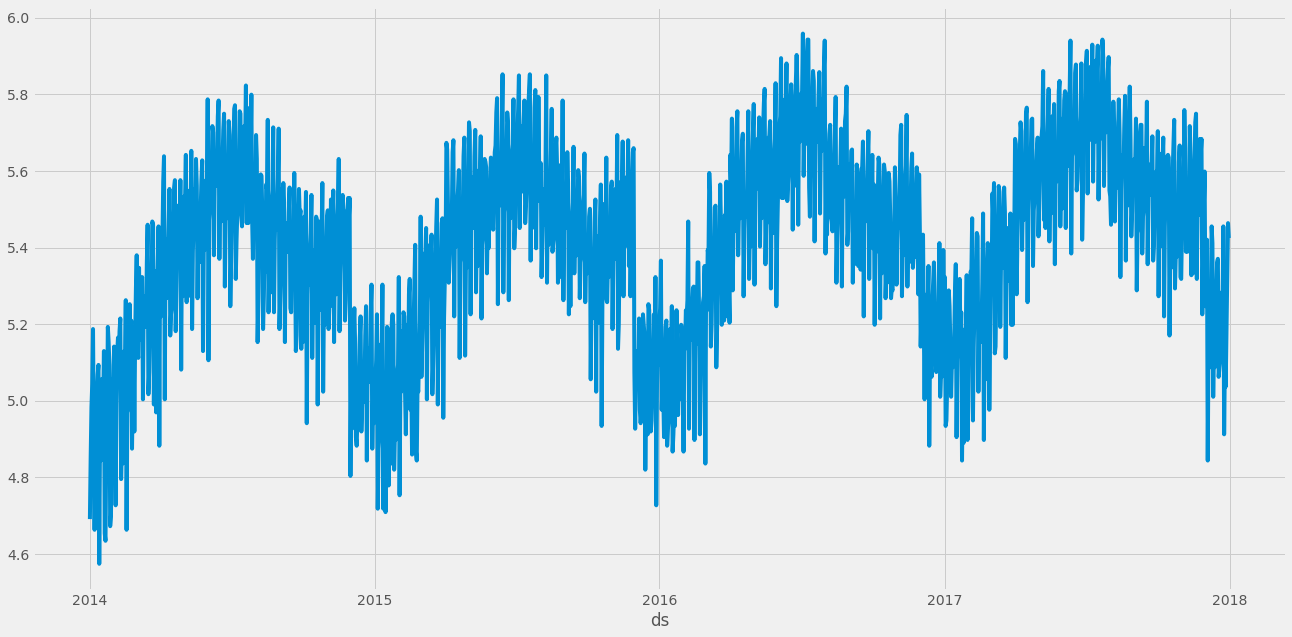

In [372]:
df['y'] = np.log(df['y'])
df.set_index('ds').y.plot()

In [373]:
model = Prophet(daily_seasonality=True,seasonality_prior_scale=0.5)
model.fit(df);
future = model.make_future_dataframe(periods=60, freq = 'd')
future.tail()


,ds
1516,2018-02-25
1517,2018-02-26
1518,2018-02-27
1519,2018-02-28
1520,2018-03-01


In [374]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1516,2018-02-25,5.501124,5.408500,5.599126
1517,2018-02-26,5.105684,5.008898,5.197376
1518,2018-02-27,5.265777,5.178833,5.362719
1519,2018-02-28,5.280880,5.183013,5.381526
1520,2018-03-01,5.343991,5.240888,5.446184


**Black points here represent the data, while the fitted model is the blue graph**

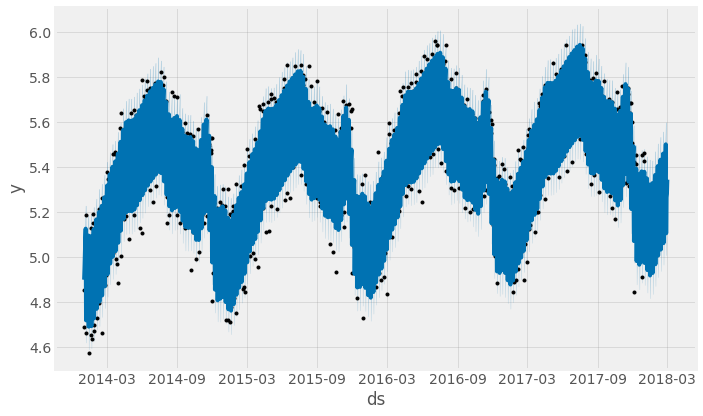

In [375]:
model.plot(forecast);


In [376]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')


In [377]:
viz_df.head()


,sales,yhat,yhat_lower,yhat_upper
2014-01-01,109.0,4.899845,4.808643,4.995281
2014-01-02,128.0,4.952120,4.858313,5.048514
2014-01-03,146.0,5.023782,4.921080,5.123321
2014-01-04,155.0,5.080253,4.981208,5.178161
2014-01-05,179.0,5.126426,5.034332,5.228946


In [378]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_rescaled
2014-01-01,109.0,4.899845,4.808643,4.995281,134.269029
2014-01-02,128.0,4.952120,4.858313,5.048514,141.474527
2014-01-03,146.0,5.023782,4.921080,5.123321,151.985092
2014-01-04,155.0,5.080253,4.981208,5.178161,160.814761
2014-01-05,179.0,5.126426,5.034332,5.228946,168.414049


**Actual sales vs Forecasted sales**

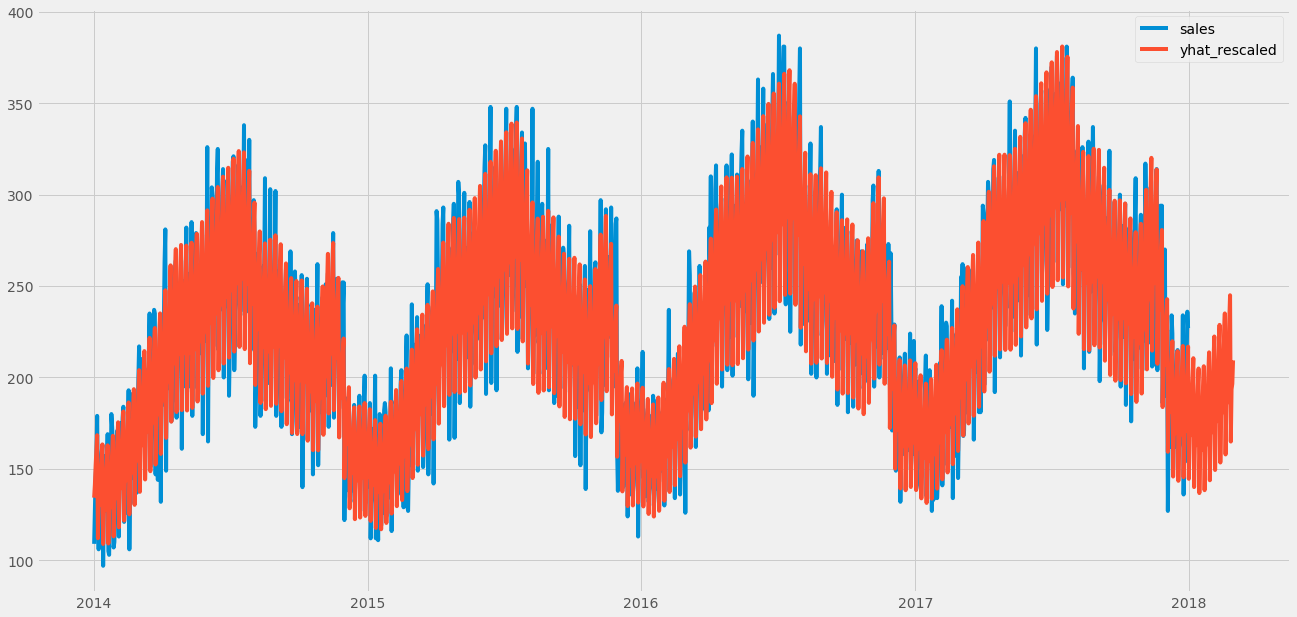

In [379]:
viz_df[['sales', 'yhat_rescaled']].plot()

In [380]:
sales_df.index = pd.to_datetime(sales_df.index) #make sure our index as a datetime object
connect_date = sales_df.index[-2] #select the 2nd to last date

mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

predict_df.head()


,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2017-12-31,5.041396,5.289650,5.481034,5.041396,5.041396,0.337841,0.337841,0.337841,0.461937,0.461937,0.461937,0.177658,0.177658,0.177658,-0.301755,-0.301755,-0.301755,0.0,0.0,0.0,5.379237
2018-01-01,5.041509,4.876264,5.067028,5.041509,5.041509,-0.067769,-0.067769,-0.067769,0.461937,0.461937,0.461937,-0.224952,-0.224952,-0.224952,-0.304754,-0.304754,-0.304754,0.0,0.0,0.0,4.973741
2018-01-02,5.041623,5.027632,5.227684,5.041623,5.041623,0.081356,0.081356,0.081356,0.461937,0.461937,0.461937,-0.072230,-0.072230,-0.072230,-0.308351,-0.308351,-0.308351,0.0,0.0,0.0,5.122979
2018-01-03,5.041736,5.016452,5.227795,5.041736,5.041736,0.084830,0.084830,0.084830,0.461937,0.461937,0.461937,-0.064640,-0.064640,-0.064640,-0.312467,-0.312467,-0.312467,0.0,0.0,0.0,5.126567
2018-01-04,5.041850,5.082288,5.273515,5.041850,5.041850,0.135808,0.135808,0.135808,0.461937,0.461937,0.461937,-0.009119,-0.009119,-0.009119,-0.317010,-0.317010,-0.317010,0.0,0.0,0.0,5.177657


In [381]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
viz_df.head()


,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2014-01-01,109.0,NaN,NaN,NaN,NaN
2014-01-02,128.0,NaN,NaN,NaN,NaN
2014-01-03,146.0,NaN,NaN,NaN,NaN
2014-01-04,155.0,NaN,NaN,NaN,NaN
2014-01-05,179.0,NaN,NaN,NaN,NaN


In [382]:
viz_df.tail()


,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2018-02-25,NaN,5.501124,5.408500,5.599126,244.967029
2018-02-26,NaN,5.105684,5.008898,5.197376,164.956901
2018-02-27,NaN,5.265777,5.178833,5.362719,193.596606
2018-02-28,NaN,5.280880,5.183013,5.381526,196.542700
2018-03-01,NaN,5.343991,5.240888,5.446184,209.346568


**Forecast for next 2 months**

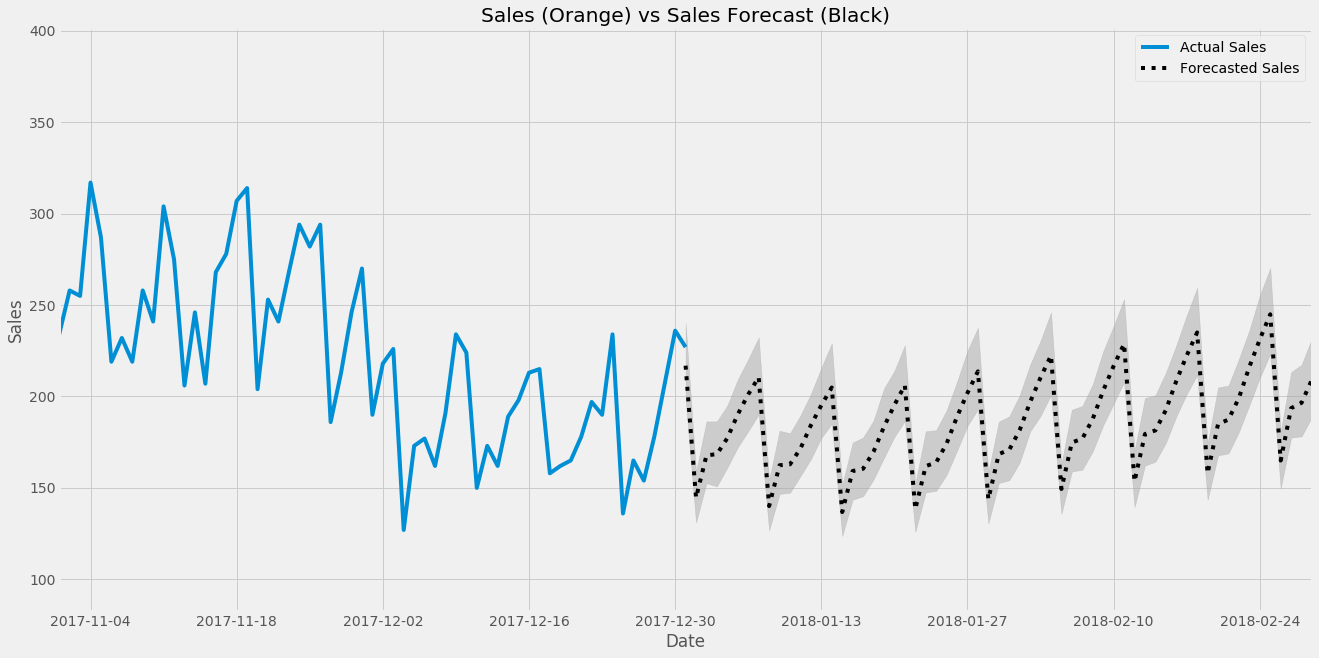

In [383]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.sales)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Sales')
ax1.set_xlabel('Date')
ax1.set_xlim(['2017-11-01', '2018-03-01'])
#fig.set_xlim(['2017-11-01', '2018-03-01'])

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot